# Code

In [98]:
%matplotlib inline

In [99]:
import os
import numpy as np
import scipy
import scipy.special
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt


class CtrlPoint(list):
    def __init__(self, *coords, **kwds):
        # Force coordinates to be floats (catch bad data values)
        super().__init__([float(coord) for coord in coords])
        self.w = float(kwds.setdefault('w', 1.0))


class Bezier(object):

    def __init__(self, ctrl_points=None):
        if not all(len(p)==len(ctrl_points[0]) for p in ctrl_points):
            raise ValueError('All control points must be the same dimension')

        self.dim = len(ctrl_points[0])
        self.ctrl_points = [CtrlPoint(*p) for p in ctrl_points]

        if len(self.ctrl_points) < 1:
            raise ValueError('There must be at least two control points')

    @property
    def deg(self):
        return len(self.ctrl_points) - 1

    @property
    def hodograph(self):
        """Calculates hodograph Bezier curve


        References
        ----------
        .. [1] Thomas W. Sederberg, "COMPUTER AIDED GEOMETRIC DESIGN"
           BYU, p. 31, 2014.

        """

        ctrl_points = []

        for i in range(self.deg):
            for j in range(self.dim):
                v = self.deg * (self.ctrl_points[i+1][j]-self.ctrl_points[i][j])
                ctrl_points.append(v)

        return Bezier(ctrl_points)

    def point(self, t):
        """Evaluate Bezier curve at a given t value"""

        p = np.zeros_like(self.ctrl_points[0])
        d = 0.0
        for i, cp in enumerate(self.ctrl_points):
            b = scipy.special.binom(self.deg, i) * (1-t)**(self.deg-i) * t**(i)
            p += cp.w*b*np.array(cp)
            d += cp.w*b
        p /= d

        return p.tolist()

    def deg_elevate(self,deg_incr):
        """Evaluate a degree elvated Bezier curve

        Parameters
        ----------
        deg_incr : int > 0
            Number of degrees to elevate

        Notes
        -----
        .. math:: P$^*_i$ = \alpha P_{i-1} + (1 - \alpha) P_i

        where α is defined as:

        .. math:: \alpha_i = \frac{i}{n+1}

        References
        ----------
        .. [1] Thomas W. Sederberg, "COMPUTER AIDED GEOMETRIC DESIGN"
           BYU, p. 23, 2014.

        """

        cp = self.ctrl_points
        for i in range(int(deg_incr)):
            p0 = np.insert(np.array(cp), 0, [cp[0]], axis=0)
            p1 = np.append(np.array(cp), [cp[0]], axis=0)
            a = np.arange(len(cp)+1) / (self.deg + i+1)
            cp = (p0*a[:,None] + p1*(1-a)[:,None]).tolist()

        return Bezier(cp)

    def nearest_point(self, point, t_guess=0.5, tol=0.000001):
        """Estimate nearest pont on bezier using fmin func

        Parameters
        ----------
        point : list
            point coordinates to evaluate
        t_guess : float, optional
            inital t guess
        tol : float, optional
            stopping tolerance
        """

        def error_fn(t_trial, p):
            return scipy.linalg.norm(p - self.point(t_trial[0]))

        npoint = np.array(point)
        t = scipy.optimize.minimize(error_fn,
                                t_guess,
                                args=(npoint,),
                                tol=tol)
        return t['x'][0]

    def error(self, points):
        errors = []
        for i, p in enumerate(points):
            t = float(i) / float(len(points))
            error = scipy.linalg.norm(p-self.nearest_point(p, t_guess=t))
            errors.append(error)
        return errors

    def de_casteljau(self, t):
        """Performs the de Casteljau algorithm to split the current Bezier
        at a given t value.

        Notes
        -----
        Use the De Casteljau's method to split the Bezier at a given t value
        and then, using the end points, calculate:

        .. math:: \kappa = \frac{n-1}{n}\frac{h}{a^2}

        where a is the length of the first leg of the control polygon,
        and h is the projected distance of the 3rd point to the first leg

        References
        ----------
        .. [1] Thomas W. Sederberg, "COMPUTER AIDED GEOMETRIC DESIGN"
           BYU, p. 31, 2014.

        """

        # Create containers for output beziers
        l_ctrl_points, r_ctrl_points = [], []

        # Use the original control points as starting points
        for i in range(self.deg+1):
            l_ctrl_points.append(np.array(self.ctrl_points[i]))
            r_ctrl_points.append(np.array(self.ctrl_points[i]))

        l_ctrl_points.reverse()

        # Walk through and perform de Casteljau's algorithm
        for i in range(self.deg):
            for j in range(self.deg-i):
                r_ctrl_points[j] = t*r_ctrl_points[j+1] + (1-t)*r_ctrl_points[j]
                l_ctrl_points[j] = t*l_ctrl_points[j]   + (1-t)*l_ctrl_points[j+1]

        l_ctrl_points.reverse()

        return Bezier(l_ctrl_points), Bezier(r_ctrl_points)

    def curvature(self, t):
        """Calculates Curvature at value t

        Notes
        -----
        Use the De Casteljau's method to split the Bezier at a given t value
        and then, using the end points, calculate:

        .. math:: \kappa = \frac{n-1}{n}\frac{h}{a^2}

        where a is the length of the first leg of the control polygon,
        and h is the projected distance of the 3rd point to the first leg

        References
        ----------
        .. [1] Thomas W. Sederberg, "COMPUTER AIDED GEOMETRIC DESIGN"
           BYU, p. 31, 2014.

        """

        def h(t, left, right):
            # Use right bezier, unless t=1.0
            if t < 1.0:
                p0 = np.array(right.ctrl_points[0])
                p1 = np.array(right.ctrl_points[1])
                p2 = np.array(right.ctrl_points[2])
            else:
                p0 = np.array(left.ctrl_points[-1])
                p1 = np.array(left.ctrl_points[-2])
                p2 = np.array(left.ctrl_points[-3])

            q = p0-p1
            r = p1-p2

            h = scipy.linalg.norm(np.cross(q, r)) / scipy.linalg.norm(q)
            return h

        def a(t, left, right):
            if t < 1.0:
                p0 = right.ctrl_points[0]
                p1 = right.ctrl_points[1]
            else:
                p0 = left.ctrl_points[-1]
                p1 = left.ctrl_points[-2]

            a = scipy.linalg.norm(np.array(p0) - np.array(p1))
            return a

        left, right = self.de_casteljau(t)

        aa = a(t, left, right)
        hh = h(t, left, right)
        n = float(self.deg)

        k = ((n-1.0)/n) * hh/(aa**2.0)
        return k

# Test Bezier

In [100]:
b = Bezier([(-1,1), (3,3), (4,-1), (2,-1)])
t_vals = scipy.linspace(0.0, 1, 100)

# Degree Elevation

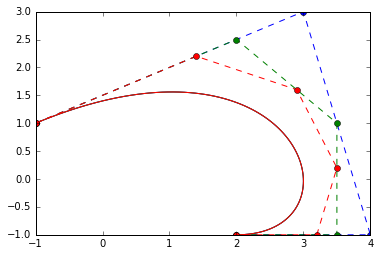

In [110]:
b1 = b.deg_elevate(1)
b2 = b.deg_elevate(2)

plt.plot([b.point(t)[0] for t in t_vals],
         [b.point(t)[1] for t in t_vals], 'b-')
plt.plot([c[0] for c in b.ctrl_points],
         [c[1] for c in b.ctrl_points], 'b--o')

plt.plot([b1.point(t)[0] for t in t_vals],
         [b1.point(t)[1] for t in t_vals], 'g-')
plt.plot([c[0] for c in b1.ctrl_points],
         [c[1] for c in b1.ctrl_points], 'g--o')

plt.plot([b2.point(t)[0] for t in t_vals],
         [b2.point(t)[1] for t in t_vals], 'r-')
plt.plot([c[0] for c in b2.ctrl_points],
         [c[1] for c in b2.ctrl_points], 'r--o')
plt.show()

# Nearest Point

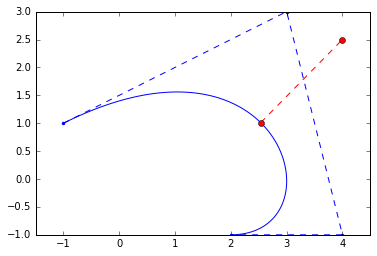

In [106]:
p = (4, 2.5)
tn = b.nearest_point(p)

plt.plot([b.point(t)[0] for t in t_vals],
         [b.point(t)[1] for t in t_vals], 'b-')
plt.plot([c[0] for c in b.ctrl_points],
         [c[1] for c in b.ctrl_points], 'b--.')
plt.plot([b.point(tn)[0], p[0]],
         [b.point(tn)[1], p[1]], 'r--o')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

# de Casteljau

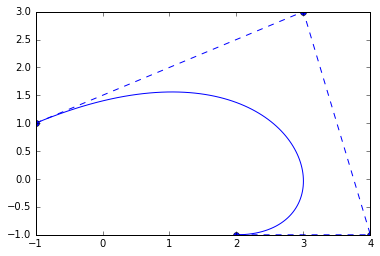

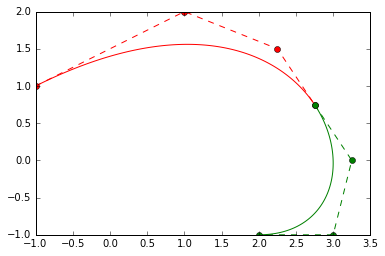

In [103]:
t_vals = scipy.linspace(0.0, 1, 100)

plt.plot([b.point(t)[0] for t in t_vals], [b.point(t)[1] for t in t_vals], 'b-')
plt.plot([p[0] for p in b.ctrl_points], [p[1] for p in b.ctrl_points], 'b--o')
plt.show()

l, r = b.de_casteljau(t=0.5)
plt.plot([l.point(t)[0] for t in t_vals], [l.point(t)[1] for t in t_vals], 'r-')
plt.plot([p[0] for p in l.ctrl_points], [p[1] for p in l.ctrl_points], 'r--o')

plt.plot([r.point(t)[0] for t in t_vals], [r.point(t)[1] for t in t_vals], 'g-')
plt.plot([p[0] for p in r.ctrl_points], [p[1] for p in r.ctrl_points], 'g--o')
plt.show()

# Regression Fit Code

In [104]:
def fit_bezier(pnts, deg):
    if int(deg) < 1:
        raise ValueError('Bezier degree must be greater than 1')
    else:
        deg = int(deg)

    pnts = np.array(pnts)

    def solve_for_cs(ds, ts, deg):
        """Takes an input series of values (ds) and uses them to solve Ax = b
        ds = values
        ts = time steps between ds

        """

        # Create A
        # am, bm = [1, 4, 6, 4, 1] (binomial array for deg 4)
        am = np.array([[scipy.special.binom(deg, i) for i in range(deg + 1)]])
        bm = np.array([[scipy.special.binom(deg, i) for i in range(deg + 1)]]).T

        # cm = matrix of 1's and -1's (based on index, e.g. for even deg: 0,0 = 1; 0,1 = -1;, 0,2 = 1, etc)
        cm = (1 - 2*np.mod(np.sum(np.indices((deg+1, deg+1)), axis=0),
            2*np.ones((deg+1, deg+1))))

        # Fix for odd deg (the array needs to be flipped... -1, 1 instead of 1, -1)
        if deg % 2:
            cm *= -1

        # A is square binomial matrix scaled by matrix of 1's and -1s (scalar of two from differentiation)
        A = 2*am*bm*cm

        # Create B
        # B is matrix of exponents for (t-1) [[8, 7, 6, 5, 4], [7, 6, 5, 4, 3], ...[4, 3, 2, 1, 0]]
        B = np.zeros((deg+1, deg+1))
        B[-1] = np.arange(deg, -1, -1)

        for i in range(deg - 1, -1, -1):
            B[i] = B[i+1] + 1

        # Create C
        # C is matrix of exponents for t [[0, 1, 2, 3, 4], [1, 2, 3, 4, 5], ...[4, 5, 6, 7, 8]]
        C = np.zeros((deg+1, deg+1))
        C[0] = np.arange(deg + 1)

        for i in range(deg):
            C[i+1] = C[i] + 1

        # Create D
        # am is 1 row matrix of binomial coefficients
        am = np.array([scipy.special.binom(deg, i) for i in range(deg + 1)])

        # bm is matrix of 1's and -1's (based on index)
        bm = (-1 + 2*np.mod(np.sum(np.indices((1, deg+1)), axis=0).flatten(), 2 * np.ones((deg+1))))

        # D is binomial coefficients scaled by matrix of 1's and -1's (scalar of two from differentiation)
        D = 2*am*bm

        # Create E
        E = np.arange(deg, -1, -1)

        # Create F
        F = np.arange(deg + 1)

        # Function to create A matrix in Ax=b (using each input from above (A, B, C))
        def A_fn(ts, Ai, Bi, Ci):
            return sum([Ai * (t - 1) ** Bi * t ** Ci for t in ts])

        def b_fn(ts, ds, Di, Ei, Fi):
            return -1.0 * sum([Di * (t - 1) ** Ei * d * t ** Fi for t, d in zip(ts, ds)])

        # Matrix A
        A = np.array([A_fn(ts, Ai, Bi, Ci) for Ai, Bi, Ci in
            zip(A.flatten(), B.flatten(), C.flatten())]).reshape((deg+1, deg+1))

        # Vector b
        b = np.array([b_fn(ts, ds, Di, Ei, Fi) for Di, Ei, Fi in
            zip(D.flatten(), E.flatten(), F.flatten())]).reshape((deg+1, 1))

        # Solve Ax = b
        return scipy.linalg.solve(A, b).ravel()

    # Set up time steps (normalized multi-dimension cummulative distances)
    dists = np.cumsum([np.linalg.norm(p) for p in np.diff(pnts, axis=0)])
    ts = [0] + [dist / max(dists) for dist in dists]

    # Fit spline through each direction independently
    ctrl_points = np.apply_along_axis(solve_for_cs, 0, pnts, ts, deg)

    return Bezier(ctrl_points)

# Regression Fit Results

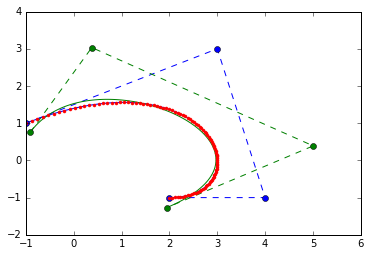

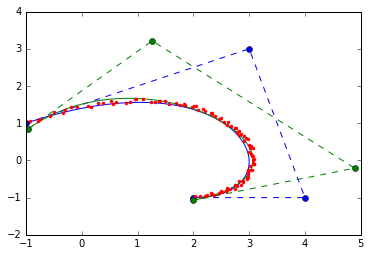

In [105]:
noise_pnts = np.array([b.point(t) for t in ts]) + 0.000001*np.random.rand(len(ts), 2)
b0 = fit_bezier(noise_pnts, b.deg)

plt.plot([b.point(t)[0] for t in ts], [b.point(t)[1] for t in ts], 'b-')
plt.plot([c[0] for c in b.ctrl_points], [c[1] for c in b.ctrl_points], 'b--o')

plt.plot([b0.point(t)[0] for t in ts], [b0.point(t)[1] for t in ts], 'g-')
plt.plot([c[0] for c in b0.ctrl_points], [c[1] for c in b0.ctrl_points], 'g--o')
plt.plot([p[0] for p in noise_pnts], [p[1] for p in noise_pnts], 'r.')
plt.show()

noise_pnts = np.array([b.point(t) for t in ts]) + 0.1*np.random.rand(len(ts), 2)
b1 = fit_bezier(noise_pnts, b.deg)

plt.plot([b.point(t)[0] for t in ts], [b.point(t)[1] for t in ts], 'b-')
plt.plot([c[0] for c in b.ctrl_points], [c[1] for c in b.ctrl_points], 'b--o')

plt.plot([b1.point(t)[0] for t in ts], [b1.point(t)[1] for t in ts], 'g-')
plt.plot([c[0] for c in b1.ctrl_points], [c[1] for c in b1.ctrl_points], 'g--o')
plt.plot([p[0] for p in noise_pnts], [p[1] for p in noise_pnts], 'r.')
plt.show()